# CME Ice Cream Model

Tamar + Orlando

January 9, 2024

In [3]:
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Circle, Patch
from matplotlib.animation import FuncAnimation
from matplotlib.patches import PathPatch
from matplotlib.path import Path

import datetime
import pandas as pd

import astrospice

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy
import sunpy.coordinates as scoords

from scipy.interpolate import interp1d

for sc in ['psp','solar orbiter'] : kernels = astrospice.registry.get_kernels(sc,'predict') 

# COLORS
scol, hcol, fcol, rcol = ['lavender', 'azure', 'lavenderblush', 'grey']
cc = ['lightpink', 'mediumspringgreen', 'peachpuff', 'powderblue', 'thistle', 'palegoldenrod']

# REGIONS
loc_hcs = [61.8, 62.2]
loc_hcs1 = [357, 358.8]
ssw = [9, 19]
fsw = [42, 52]

import tools.utilities as utils
RES_DIR = os.path.join('/Users/tamarervin/', 'e15_results')

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/tamarervin/anaconda3/envs/psp38/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [4]:
# ### READ IN DATA ###
parker, parkerdownt, parkerdownl, pss, orbiter, orbiterdownl, orbiterdownt, oss, wind, winddownt, winddownl, wss = utils.read_data(RES_DIR, sigma_time=20, pp='parker20min.csv')

### DEFINE REGIONS ###
lon_footpoints = parker.sslon
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
hhcs1 = np.logical_and(lon_footpoints >= loc_hcs1[0], lon_footpoints <=loc_hcs1[1])
slow = np.logical_and(lon_footpoints >=ssw[0], lon_footpoints <=ssw[1])
fast = np.logical_and(lon_footpoints >=fsw[0], lon_footpoints <=fsw[1])

/Users/tamarervin/publications/e15/tools/utilities.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parker['flag'][sa] = np.zeros(len(parker['flag'][sa]))
/Users/tamarervin/publications/e15/tools/utilities.py:172: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()
/Users/tamarervin/publications/e15/tools/utilities.py:172: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numer

# Spacecraft Trajectories

## Parker and Orbiter

In [5]:
# parker trajectory
dt_start,dt_end = datetime.datetime(2023,3,15),datetime.datetime(2023,4,3)
dt_common = utils.gen_dt_arr(dt_start, dt_end, cadence_days=1/48)
ts_common = np.array([dt.timestamp() for dt in dt_common])

### Create SkyCoord for PSP in the inertial (J2000) frame
psp_inertial = astrospice.generate_coords(
    'SOLAR PROBE PLUS',dt_common
)

### Create SkyCoord for SolO in the inertial (J2000) frame
solo_inertial = astrospice.generate_coords(
    'Solar Orbiter',dt_common
)

### Transform to solar co-rotating frame 
psp_carrington = psp_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)
solo_carrington = solo_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)

### Transform to inertial (HEEQ) frame
psp_HEEQ = psp_inertial.transform_to(scoords.HeliographicStonyhurst)
solo_HEEQ = solo_inertial.transform_to(scoords.HeliographicStonyhurst)


In [6]:
# Functions from https://github.com/STBadman/PSP_E10_Sources/blob/main/helpers.py

@u.quantity_input
def delta_long(r:u.R_sun,
               r_inner=2.5*u.R_sun,
               vsw=360.*u.km/u.s,
               omega_sun=14.713*u.deg/u.d,
               ):
    """ 
    Ballistic longitudinal shift of a Parker spiral connecting two
    points at radius r and r_inner, for a solar wind speed vsw. Solar
    rotation rate is also tunable
    """
    return (omega_sun * (r - r_inner) / vsw).to("deg")

def ballistically_project(skycoord,r_inner = 2.5*u.R_sun, vr_arr=None) :
    """
    Given a `SkyCoord` of a spacecraft trajectory in the Carrington frame,
    with `representation_type="spherical"`, and optionally an array of
    measured solar wind speeds at the same time intervals of the trajectory,
    return a SkyCoord for the trajectory ballistically projected down to 
    `r_inner` via a Parker spiral of the appropriate curvature. When `vr_arr`
    is not supplied, assumes wind speed is everywhere 360 km/s
    """
    if vr_arr is None : vr_arr = np.ones(len(skycoord))*360*u.km/u.s
    lons_shifted = skycoord.lon + delta_long(skycoord.radius,
                                             r_inner=r_inner,
                                             vsw=vr_arr
                                            )
    return SkyCoord(
        lon = lons_shifted, 
        lat = skycoord.lat,
        radius = r_inner * np.ones(len(skycoord)),
        representation_type="spherical",
        frame = skycoord.frame
    )

In [7]:
### GENERATE VELOCITY ARRAYS
psp_vr_common = interp1d(np.array([dt.timestamp() for dt in parker.Time]),parker.vr,bounds_error=False)(ts_common)*u.km/u.s
solo_vr_common = interp1d(np.array([dt.timestamp() for dt in orbiter.Time]),orbiter.vr,bounds_error=False)(ts_common)*u.km/u.s

### BALLISTICALLY PROJECT
psp_projected = ballistically_project(psp_carrington,vr_arr=psp_vr_common)
solo_projected = ballistically_project(solo_carrington,vr_arr=solo_vr_common)

## MMS

In [8]:
### MMS Composition Data
mms = pd.read_csv(os.path.join(RES_DIR, 'mms.csv'))
mms['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f') for d in mms.Time]
mms.columns

### MMS Bow Shock Crossings
bowshock = pd.read_csv(os.path.join(RES_DIR, 'bowShockCrossings.txt'), sep=', ', index_col=None)
bowshock['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M') for d in bowshock.Time]
inbound = bowshock.iloc[np.where(bowshock=='IB')[0]].copy()
outbound = bowshock.iloc[np.where(bowshock=='OB')[0]].copy()

### MMS Magnetosphere Events
magnetosphere = pd.read_csv(os.path.join(RES_DIR, 'magnetosphereEventList.txt'), sep=', ', index_col=None)
magnetosphere['TimeIn'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M') for d in magnetosphere.TimeIn]
magnetosphere['TimeOut'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M') for d in magnetosphere.TimeOut]



/var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_4416/281109111.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  bowshock = pd.read_csv(os.path.join(RES_DIR, 'bowShockCrossings.txt'), sep=', ', index_col=None)
/var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_4416/281109111.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  magnetosphere = pd.read_csv(os.path.join(RES_DIR, 'magnetosphereEventList.txt'), sep=', ', index_col=None)


In [9]:
files = np.sort(glob.glob(os.path.join(RES_DIR, 'pydata/mms1/mec/srvy/l2/epht89q/2023/03/', "*"), recursive=True))
import cdflib
time, Xgse, Ygse, Zgse = [], [], [], []
# coords, tt = [], []
for f in files:
    data_cdf = cdflib.CDF(f) 
    ### READ IN VARIABLE INFO
    time.extend((cdflib.cdfepoch.to_datetime(data_cdf.varget("Epoch"))))
    Xgse.extend((data_cdf.varget("mms1_mec_r_gse")[:, 0]))
    Ygse.extend((data_cdf.varget("mms1_mec_r_gse")[:, 1]))
    Zgse.extend((data_cdf.varget("mms1_mec_r_gse")[:, 2]))

### TRANSFORM TO HELIOGRAPHIC CARRINGTON
mms1_gse = SkyCoord(np.array(Xgse)*u.km, np.array(Ygse)*u.km, np.array(Zgse)*u.km, frame=sunpy.coordinates.frames.GeocentricSolarEcliptic, representation_type='cartesian', obstime=np.array(time))
mms_carrington = mms1_gse.transform_to(
    scoords.HeliographicCarrington(observer="self"))
mms_carrington.representation_type = 'spherical'

In [10]:
mms_carrington

<SkyCoord (HeliographicCarrington: obstime=[datetime.datetime(2023, 3, 21, 0, 0)
 datetime.datetime(2023, 3, 21, 0, 0, 30)
 datetime.datetime(2023, 3, 21, 0, 1) ...
 datetime.datetime(2023, 3, 31, 23, 58, 30)
 datetime.datetime(2023, 3, 31, 23, 59)
 datetime.datetime(2023, 3, 31, 23, 59, 30)], rsun=695700.0 km, observer=self): (lon, lat, radius) in (deg, deg, km)
    [( 44.52070265, -7.0312046 , 1.48980521e+08),
     ( 44.51616677, -7.03119865, 1.48980452e+08),
     ( 44.51163077, -7.03119274, 1.48980382e+08), ...,
     (259.50045893, -6.57897969, 1.49379020e+08),
     (259.49588772, -6.57896733, 1.49379000e+08),
     (259.49131651, -6.57895496, 1.49378980e+08)]>

## Wind

In [11]:
import astropy.constants as const
# import heliopy.spice as spice
def get_sc_trajectory(datetime_arr,spice_str='L1',
                      origin='Sun',frame='IAU_SUN',
                      representation_type="cartesian",
                      incl_datetimes = False
                      ) :
    print(spice_str)
    if spice_str == 'L1' :
        spice_str = 'Earth'
        modifier= 1.0- ((const.M_earth.value/
                        (const.M_earth.value
                         +const.M_sun.value))/3)**(1/3)
    else : modifier= 1.0
    try : sc = spice.Trajectory(spice_str)
    except :
        valid_strings = [
        'SPP','Earth','L1','SOLO', 'Venus', 'BEPICOLOMBO MPO',
        ]
        return f"Invalid spice string, choose from {valid_strings}"
    sc.generate_positions(datetime_arr, origin, frame)
    sc.change_units(u.au)
    if len(datetime_arr) == 1 or not incl_datetimes:
        sc_coord = SkyCoord(x=sc.x*modifier,
                                  y=sc.y*modifier,
                                  z=sc.z*modifier,
                                  frame= sunpy.coordinates.HeliographicCarrington,
                                  representation_type='cartesian',
                                  observer="Earth",
                                  obstime = datetime_arr[0],
                                  )
    else :
        sc_coord = SkyCoord(x=sc.x*modifier,
                                  y=sc.y*modifier,
                                  z=sc.z*modifier,
                                  frame= sunpy.coordinates.HeliographicCarrington,
                                  representation_type='cartesian',
                                  observer="Earth",
                                  obstime = list(datetime_arr),
                                  )
    sc_coord.representation_type=representation_type
    return sc_coord

In [12]:
l1_factor = 0.99029
wind_carrington = get_sc_trajectory(dt_common, spice_str='L1')
# wind_carrington.representation_type = 'spherical'
wind_carrington = SkyCoord(lon=wind_carrington.lon, lat=wind_carrington.lat, radius=wind_carrington.radius*l1_factor, representation_type="spherical",
                          frame = wind_carrington.frame)

L1


AttributeError: 'str' object has no attribute 'lon'

# Look at AIA and LASCO

In [ ]:

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors

import astropy.units as u

import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a
import sunpy.visualization.colormaps as cm

from sunpy.map.header_helper import make_heliographic_header
from astropy.coordinates import SkyCoord

import hvpy
import matplotlib.pyplot as plt
from hvpy.datasource import DataSource

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.data.sample
from sunpy.coordinates import Helioprojective
from sunpy.map import Map
from sunpy.util.config import get_and_create_download_dir

## AIA

In [8]:
### DOWNLOAD AIA IMAGES
# data parameters
cadence = a.Sample(10*u.minute)  # querying cadence
start_date = '2023-03-15T06:40:00'  # start date of query
end_date = '2023-03-15T07:10:00'  # end date of query

# query data
aia_result = Fido.search(a.Time(start_date, end_date),
                     a.Instrument.aia, a.Wavelength(193 * u.angstrom), cadence)
file_download = Fido.fetch(aia_result)
map_seq = sunpy.map.Map(sorted(file_download))

# read result dataframe
aia_result

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size
,,,,Angstrom,,,,,,,Mibyte
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64
2023-03-15 06:40:04.000,2023-03-15 06:40:05.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2023-03-15 06:50:04.000,2023-03-15 06:50:05.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2023-03-15 07:00:04.000,2023-03-15 07:00:05.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844


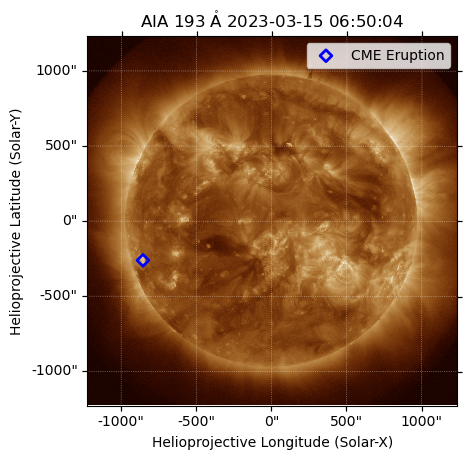

In [9]:
aia_map = map_seq[1]

fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)

## FIGURE
aia_map.plot(axes=ax)
coords = SkyCoord(Tx=-856*u.arcsec, Ty=-261*u.arcsec, frame=aia_map.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(aia_map.wcs)
ax.scatter(pixel_coords_x, pixel_coords_y, marker='D', zorder=3, facecolor='none', edgecolor='blue', linewidth=2, label='CME Eruption')
ax.legend()

## LASCO

In [11]:
lasco_jp2_file = hvpy.save_file(hvpy.getJP2Image(datetime(2023, 3, 15, 6, 48),
                                                 DataSource.LASCO_C2.value),
                                filename=get_and_create_download_dir() + "/LASCO_C2_20230315T0648.jp2", overwrite=True)
lasco_map = Map(lasco_jp2_file)
lasco_map.coordinate_frame

TypeError: 'module' object is not callable

In [11]:
coords = SkyCoord(Tx=-856*u.arcsec, Ty=-261*u.arcsec, frame=aia_map.coordinate_frame)
coords = coords.transform_to(lasco_map.coordinate_frame)
coords = coords.transform_to(scoords.frames.Heliocentric)
coords.representation_type = 'cylindrical'
coords

<SkyCoord (Heliocentric: obstime=2023-03-15T06:48:10.998, observer=<HeliographicStonyhurst Coordinate (obstime=2023-03-15T06:48:10.998, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -7.17459641, 1.48745692e+11)>): (rho, psi, z) in (m, deg, m)
    (6.44379548e+08, 196.95445433, 2.63037329e+08)>

In [12]:
# coords from lasco catalog (R, phi)
lasco_rho = [4.35, 6.24, 6.82, 8.42, 9.65, 10.19, 12.0]
lasco_phi = [111.5, 112.9, 108.6, 115.6, 113.6, 111.0, 112.3]
z = [2.63037329e+08] * 7

lasco_x = [rr * np.cos(np.deg2rad(pp)) for rr, pp in zip(lasco_rho, lasco_phi)]
lasco_y = [rr * np.sin(np.deg2rad(pp)) for rr, pp in zip(lasco_rho, lasco_phi)]
lasco_x, lasco_y

([-1.5942803362506925,
  -2.428133448874888,
  -2.1753024894128368,
  -3.6381620049126884,
  -3.863368164174035,
  -3.6517694058666095,
  -4.553473914348061],
 [4.047316420721806,
  5.7481969307301,
  6.463780556265375,
  7.593429872331059,
  8.842900340275612,
  9.513184546006485,
  11.102516620629386])

In [13]:
lasco_catalog = SkyCoord(Tx=[-1.09*u.deg, -1.54*u.deg, -1.73*u.deg, -2.04*u.deg], 
                         Ty=[-1516*u.arcsec, -2306*u.arcsec, -2078*u.arcsec, -3472*u.arcsec], 
                         frame='helioprojective', observer=lasco_map.observer_coordinate)
# lasco_catalog.transform_to(scoords.frames.Heliocentric)
# lasco_catalog.representation_type = 'cylindrical'
print(lasco_catalog)


<SkyCoord (Helioprojective: obstime=2023-03-15T06:48:10.998, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2023-03-15T06:48:10.998, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (0., -7.17459641, 0.99430354)>): (Tx, Ty) in arcsec
    [(-3924., -1516.), (-5544., -2306.), (-6228., -2078.),
     (-7344., -3472.)]>


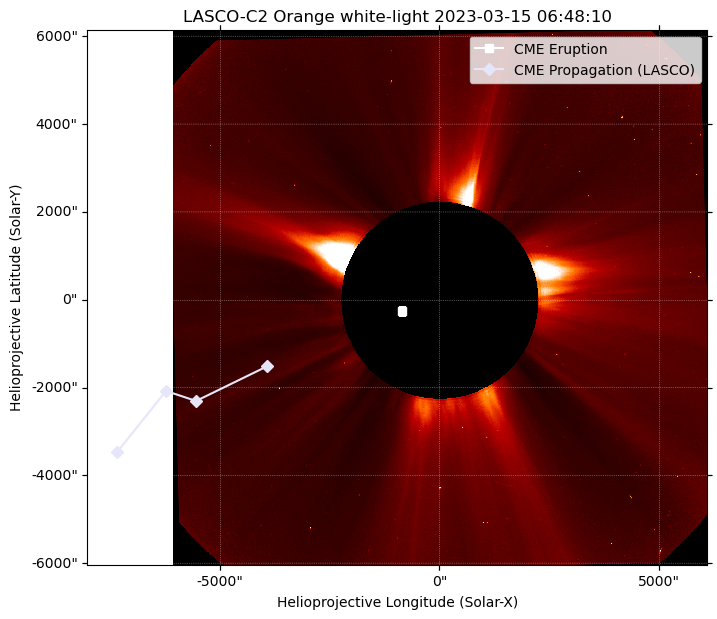

In [14]:
# psptraj = SkyCoord(psp_carrington.lon, psp_carrington.lat, psp_carrington.radius, frame=psp_carrington.frame).transform_to(lasco_map.coordinate_frame)
# psptraj_proj = SkyCoord(psp_projected.lon, psp_projected.lat, psp_projected.radius, frame=psp_projected.frame).transform_to(lasco_map.coordinate_frame)

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(projection=lasco_map)
lasco_map.plot(axes=ax)
# ax.plot_coord(psptraj[12], color='green', marker='*', markersize=6, zorder=3)
# ax.plot_coord(psptraj_proj, color='b', marker='*', markersize=6, zorder=3, label='PSP at $R_{ss}$ at Eruption')
ax.plot_coord(coords, color='white', marker='s', zorder=5, label='CME Eruption')
ax.plot_coord(lasco_catalog, color='lavender', marker='D', zorder=5, label='CME Propagation (LASCO)')

ax.legend(loc = 'upper right')

In [16]:
projected_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                           obstime=lasco_map.observer_coordinate.obstime,
                           frame='helioprojective',
                           observer=lasco_map.observer_coordinate,
                           rsun=aia_map.coordinate_frame.rsun)
projected_header = sunpy.map.make_fitswcs_header(aia_map.data.shape,
                                                 projected_coord,
                                                 scale=u.Quantity(aia_map.scale),
                                                 instrument=aia_map.instrument,
                                                 wavelength=aia_map.wavelength)
### REPROJECT AIA IMAGE
with Helioprojective.assume_spherical_screen(aia_map.observer_coordinate):
    aia_reprojected = aia_map.reproject_to(projected_header)

### REPROJECT ERUPTION COORDINATES
coords = SkyCoord(Tx=-856*u.arcsec, Ty=-261*u.arcsec, frame=aia_map.coordinate_frame)
coords = coords.transform_to(frame=aia_reprojected.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(aia_reprojected.wcs)

In [ ]:
## FIGURE
fig = plt.figure()
ax = fig.add_subplot(projection=lasco_map)
lasco_map.plot(axes=ax)
aia_reprojected.plot(axes=ax, clip_interval=(1, 99.9)*u.percent, autoalign=True)

### ERUPTION 
# ax.scatter(pixel_coords_x, pixel_coords_y, marker='D', zorder=3, facecolor='none', edgecolor='blue', linewidth=2, label='CME Eruption')
# ax.legend()

plt.savefig('c2_aia_20230315T0648.png')

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


# Create Cone model

Inputs: 
- eruption position:
- angular width
- central PA
- velocity
- acceleration
- eruption time at March 15 06:48, Parker observed eruption at 10:00
- parker observed low density region at March 16 12:00

In [15]:
def ice_cream_model(alpha, r):
    
    # calculate semi-circle radius
    a = r * np.tan(alpha / 2) / (1 + np.tan(alpha / 2))

    # calculate triangle lengths
    l = np.sqrt((r - a)**2 + a**2)  # triangle leg
    h = r - a  # triangle height

    return a, l, h

In [ ]:
# March 15, 2023 06:48 CME parameters
coords = coords.transform_to(frame=scoords.HeliographicCarrington)
center_coordinates = (coords.lon.value, coords.lat.value, coords.radius.to(u.Rsun).value) 
center_polar = (1*u.Rsun, 107*u.deg)
angular_width = 35*u.deg  
initial_radius = 8.5*u.R_sun
velocity = 750*u.km/u.s  # velocity at radial position in km/s
num_steps = 10
time_step = 5 * u.hour 


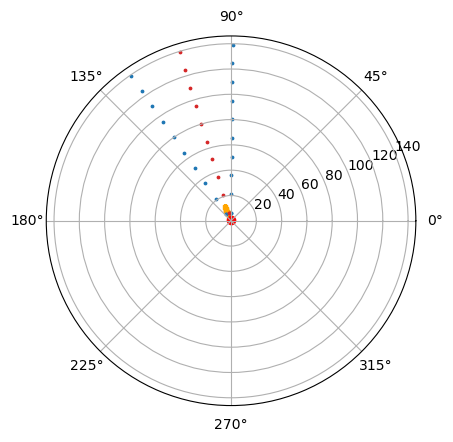

In [ ]:
# Plot original triangle and semi circle
a, l, h = ice_cream_model(angular_width, initial_radius)

### CREATE FIGURE
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ss, lw = 3, 3
ec, erupc = 'tab:blue', 'tab:red'
ax.set_rmax(50)

# lasco coordinates
ax.scatter(np.deg2rad(lasco_phi), lasco_rho, c='orange', s=10, marker='s')

# Plot the Sun
circle_theta = np.linspace(0, 2*np.pi, 100)
circle_radius = np.ones(100)
ax.fill(circle_theta, circle_radius, color='gold')

# plot the eruption
r, p = coords.radius.to(u.Rsun), coords.lon
rho, phi = center_coordinates[2], np.deg2rad(center_coordinates[0])

r, p = center_polar
rho, phi = center_polar[0], np.deg2rad(center_polar[1])

ax.scatter(phi, rho, c='red', marker='o')

# plot the triangle
p1 = p + np.arctan(a / h)
p2 = p - np.arctan(a / h)
phi1, rho1 = np.deg2rad(p1), h.value
phi2, rho2 = np.deg2rad(p2), h.value
ax.scatter(phi1, rho1, c=ec, marker='o', s=ss)
ax.scatter(phi2, rho1, c=ec, marker='o',  s=ss)
ax.scatter(phi, rho1, c=erupc, marker='o',  s=ss)

# propagate this outwards
for i in range(num_steps):
    new_radius = initial_radius + i * velocity * time_step
    a, l, h = ice_cream_model(angular_width, new_radius)
    p1 = p + np.arctan(a / h)
    p2 = p - np.arctan(a / h)
    phi1, rho1 = np.deg2rad(p1), h.value
    phi2, rho1 = np.deg2rad(p2), h.value
    ax.scatter(phi1, rho1, c=ec, marker='o', s=ss)
    ax.scatter(phi2, rho1, c=ec, marker='o',  s=ss)
    ax.scatter(phi, rho1, c=erupc, marker='o',  s=ss)

# # plot the parker trajectory
# ax.scatter(np.deg2rad(psp_carrington.lon.value), psp_carrington.radius.to(u.Rsun).value, c='k', marker='o',  s=ss, label='Parker')
# ax.scatter(np.deg2rad(solo_carrington.lon.value), solo_carrington.radius.to(u.Rsun).value, c='tab:purple', marker='o',  s=ss, label='Solar Orbiter')




# In X/Y Carrington Coordinates

## Setup

In [10]:
def ice_cream_model(alpha, r):
    
    # calculate semi-circle radius
    a = r * np.tan(alpha / 2) / (1 + np.tan(alpha / 2))

    # calculate triangle lengths
    l = np.sqrt((r - a)**2 + a**2)  # triangle leg
    h = r - a  # triangle height

    return a, l, h

In [11]:
# March 15, 2023 06:48 CME parameters
angular_width = 35*u.deg  # Replace with your actual angular width in degrees
initial_radius = 8.5*u.R_sun
velocity = 750*u.km/u.s  # velocity at radial position in km/s
accel = - 70 * u.km / (u.s ** 2)
num_steps = 10
time_step = 5 * u.hour # in seconds

In [12]:
# Eruption coordinates
coords = SkyCoord(Tx=-856*u.arcsec, Ty=-261*u.arcsec, frame=aia_map.coordinate_frame)
coords = coords.transform_to(frame=scoords.HeliocentricInertial)
coords.representation_type="cartesian"
x0, y0 = coords.x.to(u.Rsun), coords.y.to(u.Rsun)
coords

<SkyCoord (HeliocentricInertial: obstime=2023-03-15T06:50:04.840): (x, y, z) in m
    (5.75059169e+08, 3.25015918e+08, -2.19288862e+08)>

In [ ]:
# # LASCO Coordinates
# lasco_catalog = SkyCoord(Tx=[-1.09*u.deg, -1.54*u.deg, -1.73*u.deg, -2.04*u.deg], 
#                          Ty=[-1516*u.arcsec, -2306*u.arcsec, -2078*u.arcsec, -3472*u.arcsec], 
#                          frame='helioprojective', observer=lasco_map.observer_coordinate)

# with Helioprojective.assume_spherical_screen(aia_map.observer_coordinate):
#     # lasco_catalog = lasco_catalog.transform_to(scoords.HeliographicCarrington)
#     lasco_catalog = lasco_catalog.transform_to(scoords.HeliocentricInertial)

# lasco_catalog.representation_type = 'cartesian'
# xL, yL = lasco_catalog.x.to(u.Rsun), lasco_catalog.y.to(u.Rsun)
# xL, yL

(<Quantity [4.04572592, 5.71451418, 6.40879405, 7.56984377] solRad>,
 <Quantity [0.44366552, 0.63299608, 0.78307183, 0.82986876] solRad>)

In [31]:
def parker_streamline(projected,
                      r0=1.0*u.R_sun,
                      w_s=(2.*np.pi)/(24.47*(24*3600))*u.rad/u.s,
                      v_sw=360*u.km/u.s,
                      rmax=215*u.R_sun,
                      sampling=500
                     ) :
    """Starting from an inner polar coordinatate ({r0},{phi0}), trace
    a ballistic spiral out to {rmax} with curvature set by a solar wind
    speed of {v_sw} with {sampling} gridpoints
    """

    coordinates = []
    
    # radius
    r = np.linspace(r0,rmax,sampling)

    # velocity 
    phi1 = (-w_s/(v_sw + 50 *u.km/u.s)*(r-r0)).to(u.deg) + projected.lon
    phi2 = (-w_s/(v_sw - 50 *u.km/u.s)*(r-r0)).to(u.deg) + projected.lon

    for phi in [phi1, phi2]:
        coords = SkyCoord(
            lon = phi.to(u.deg),
            lat = projected.lat, 
            radius = r.to(u.Rsun),
            frame = scoords.HeliographicCarrington, 
            obstime=projected.obstime.value,
            observer=projected.observer
        )

        coords = coords.transform_to(scoords.HeliocentricInertial)
        coords.representation_type = 'cartesian'
        coordinates.append(coords)

    return coordinates

In [104]:
def parker_streamline(projected,
                      r0=1.0*u.R_sun,
                      w_s=(2.*np.pi)/(24.47*(24*3600))*u.rad/u.s,
                      v_sw=250*u.km/u.s,
                      rmax=215*u.R_sun,
                      sampling=500
                     ) :
    """Starting from an inner polar coordinatate ({r0},{phi0}), trace
    a ballistic spiral out to {rmax} with curvature set by a solar wind
    speed of {v_sw} with {sampling} gridpoints
    """

    coordinates = []
    
    # radius
    r = np.linspace(r0,rmax,sampling)

    # velocity 
    phi1 = (-w_s/(v_sw)*(r-r0)).to(u.deg) + 9 * u.deg
    phi2 = (-w_s/(v_sw)*(r-r0)).to(u.deg) + 19 * u.deg

    for phi in [phi1, phi2]:
        coords = SkyCoord(
            lon = phi.to(u.deg),
            lat = 0 * u.deg, 
            radius = r.to(u.Rsun),
            frame = scoords.HeliographicCarrington, 
            obstime=projected.obstime.value,
            observer='self'
        )

        coords = coords.transform_to(scoords.HeliocentricInertial)
        coords.representation_type = 'cartesian'
        coordinates.append(coords)

    return coordinates

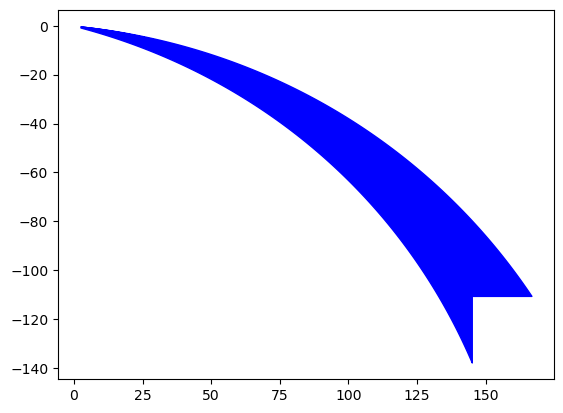

In [80]:
# for vsw in np.arange(psp_vr_common[0].value-20, psp_vr_common[0].value+20, step=2):
pcoords = parker_streamline(projected=psp_projected[0],
                    r0 = 2.5*u.R_sun,
                    rmax = 200*u.R_sun,
                    v_sw=psp_vr_common[0]
                    )

plt.fill_between(pcoords[0].x.value, pcoords[0].y.value, pcoords[1].y.value, color='b')
plt.fill_betweenx(pcoords[1].y.value, pcoords[0].x.value, pcoords[1].x.value, color='b')


## Movie

In [2]:
### Trajectories
psp_coords = psp_inertial.transform_to(scoords.HeliocentricInertial)
psp_coords.representation_type="cartesian"

solo_coords = solo_inertial.transform_to(scoords.HeliocentricInertial)
solo_coords.representation_type="cartesian"

mms_coords = mms_carrington.transform_to(scoords.HeliocentricInertial)
mms_coords.representation_type = 'cartesian'

wind_coords = wind_carrington.transform_to(scoords.HeliocentricInertial)
wind_coords.representation_type = 'cartesian'

NameError: name 'psp_inertial' is not defined

In [1]:
def parker_streamline(phi0=0.0*u.deg,
                      r0=1.0*u.R_sun,
                      w_s=(2.*np.pi)/(24.47*(24*3600))*u.rad/u.s,
                      v_sw=360*u.km/u.s,
                      rmax=215*u.R_sun,
                      sampling=500,
                     ) :
    """Starting from an inner polar coordinatate ({r0},{phi0}), trace
    a ballistic spiral out to {rmax} with curvature set by a solar wind
    speed of {v_sw} with {sampling} gridpoints
    """
    # Output r :: Rs, phi :: deg
    r = np.linspace(r0,rmax,sampling)
    phi = -w_s/v_sw*(r-r0) + phi0
    return r.to("R_sun"),phi.to("deg")
    
use = np.logical_and(psp_projected.lon.value>=ssw[0], psp_projected.lon.value<=ssw[1])
psp_streamlines = [
    parker_streamline(
        phi0=lon*u.deg,
        r0 = 2.5*u.Rsun, 
        rmax = 300*u.R_sun,
        v_sw = v*u.km/u.s)
    for lon,v in zip(np.linspace(9, 19, 500),np.linspace(300, 500, 500))]

for psp_spiral,psp_v,pspc in zip(
        psp_streamlines,
        psp_vr_common,
        psp_carrington
    ):
    ax.plot((psp_spiral[0]*np.cos(psp_spiral[1])),
                 (psp_spiral[0]*np.sin(psp_spiral[1])),
                 color =scol, zorder=-1
                ) 

NameError: name 'u' is not defined

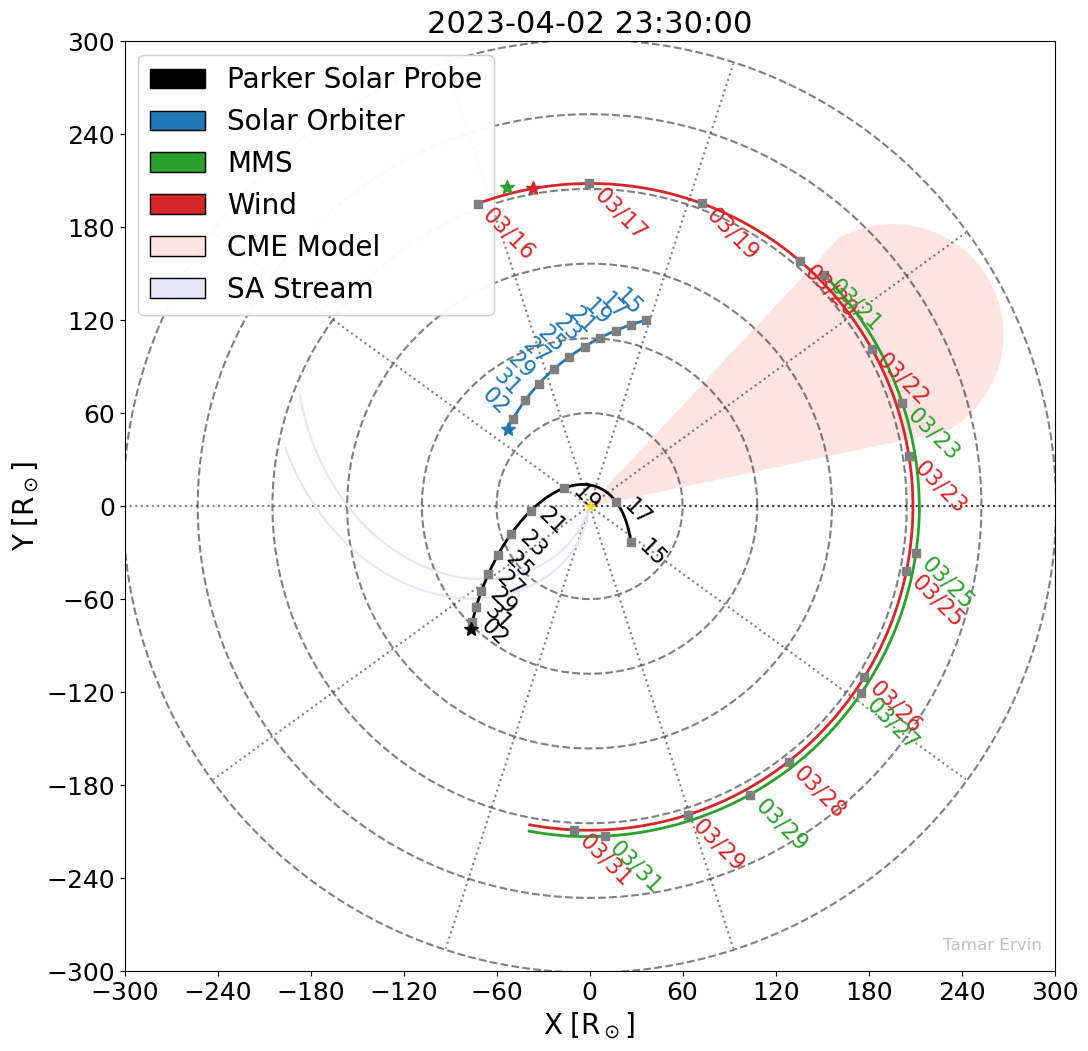

In [105]:
### Set up axes
fig, ax = plt.subplots(1, figsize=(12,15))

### Gridlines / Axis Lables ETC for ax
ax.set_aspect(1)
rmax=300
rgrids = np.linspace(60, rmax+1, 6)
for R_ in rgrids  :
    ax.plot(R_*np.cos(np.linspace(0,2*np.pi,300)),
            R_*np.sin(np.linspace(0,2*np.pi,300)),
            color="black",linestyle="--",alpha=0.5
           )
rmax=rmax    
for phi in np.radians(np.linspace(0,360,11)) :
    ax.plot([0,rmax*np.cos(phi)],[0,rmax*np.sin(phi)],
            color="black",linestyle=":",alpha=0.5
           )
ax.set_xticks(np.linspace(-rmax,rmax,11))
ax.set_yticks(np.linspace(-rmax,rmax,11))
ax.set_xlim([-rmax,rmax])
ax.set_ylim([-rmax,rmax])
ax.set_xlabel(r"$\rm X \; [R_\odot]$", fontsize=20)
ax.set_ylabel(r"$\rm Y \; [R_\odot]$", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 

############ --------------- TRAJECTORIES --------------- ############
days=2
cp, cs, cw, cm, dcol = ['black', 'tab:blue', 'tab:red', 'tab:green', 'tab:gray']
label_cadence = 48*days
cc = ['r', 'orange', 'green', 'blue', 'purple', 'pink']
c_cme = 'mistyrose'

### PARKER
psp_coords.representation_type="cartesian"
ax.plot(
    psp_coords.x.to("R_sun"),
    psp_coords.y.to("R_sun"),
    color=cp,linewidth=2,zorder=10
)
ax.scatter(
    psp_coords.x.to("R_sun")[::label_cadence],
    psp_coords.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10
)

### ORBITER
solo_coords.representation_type="cartesian"
ax.plot(
    solo_coords.x.to("R_sun"),
    solo_coords.y.to("R_sun"),
    color=cs,linewidth=2,zorder=10
)
ax.scatter(
    solo_coords.x.to("R_sun")[::label_cadence],
    solo_coords.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10
)

### WIND
wc=720*days
wind_carrington.representation_type="cartesian"
ax.plot(
    wind_carrington.x.to("R_sun"),
    wind_carrington.y.to("R_sun"),
    color=ca,linewidth=2,label="Wind",zorder=10
)
ax.scatter(
    wind_carrington.x.to("R_sun")[::wc],
    wind_carrington.y.to("R_sun")[::wc],
    color=dcol, marker='s',zorder=10
)

### MMS
mc=2880*days
mms_carrington.representation_type="cartesian"
ax.plot(
    mms_carrington.x.to("R_sun"),
    mms_carrington.y.to("R_sun"),
    color=cm,linewidth=2,label="MMS",zorder=10
)
ax.scatter(
    mms_carrington.x.to("R_sun")[::mc],
    mms_carrington.y.to("R_sun")[::mc],
    color=dcol, marker='s',zorder=10
)

### LABEL DATES
for dt,pspc,soc in zip(dt_common[::label_cadence],
                       psp_coords[::label_cadence],
                       solo_coords[::label_cadence]) :
    ax.text(pspc.x.to("R_sun").value+2,
                 pspc.y.to("R_sun").value+5,
                f"{dt.day:02d}",rotation=-45,color=cp,
                verticalalignment="top",
                horizontalalignment="left",zorder=10,fontsize=16
               )
    ax.text(soc.x.to("R_sun").value,
                 soc.y.to("R_sun").value,
                 f"{dt.day:02d}",rotation=-45,color=cs,
                 verticalalignment="bottom",
                 horizontalalignment="right",zorder=10,
                 fontsize=16
               )
for dt, wsc in zip(wind_carrington.obstime.datetime[::wc],
                    wind_carrington[::wc]):
    ax.text(wsc.x.to("R_sun").value,
                    wsc.y.to("R_sun").value,
                    f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=ca,
                    verticalalignment="top",
                    horizontalalignment="left",zorder=10,fontsize=16
                )
for dt, mmsc in zip(mms_carrington.obstime.datetime[::mc],
                    mms_carrington[::mc]):
    ax.text(mmsc.x.to("R_sun").value,
                    mmsc.y.to("R_sun").value,
                    f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cm,
                    verticalalignment="top",
                    horizontalalignment="left",zorder=10,fontsize=16
                )


############ SUN
ax.scatter(0, 0, c='gold', marker='*', s=40, zorder=10)

############ CME
ss, lw, mm = 10, 3, 'D'
ec, erupc = 'tab:orange', 'tab:red'

# Plot original triangle and semi circle
a, l, h = ice_cream_model(angular_width, initial_radius)

# eruption location
r, p = np.sqrt(x0**2 + y0**2), np.arctan(y0/x0)

### SETUP FIGURE
title = ax.set_title([], fontsize=22)
psp, = ax.plot([], [], marker='*', ms=ss, c=cp, zorder=12)
solo, = ax.plot([], [], marker='*', ms=ss, c=cs, zorder=12)
mcoords, = ax.plot([], [], marker='*', ms=ss, c=cm, zorder=12)
wcoords, = ax.plot([], [], marker='*', ms=ss, c=cw, zorder=12)
cme_triangle, = ax.fill(np.zeros(3), np.zeros(3), color=c_cme)
cme_semicircle, = ax.fill(np.zeros(100), np.zeros(100), color=c_cme)
# safill, = ax.fill_between(np.zeros(1), np.zeros(1), np.zeros(1), color=scol)
# safillx, = ax.fill_between([], [], [], color=scol)
sa1, = ax.plot([], [], color=scol)
sa2, = ax.plot([], [], color=scol)

### LEGEND ###
psp_patch = Patch(facecolor=cp, edgecolor='k', label='Parker Solar Probe')
solo_patch = Patch(facecolor=cs, edgecolor='k', label='Solar Orbiter')
mms_patch = Patch(facecolor=cm, edgecolor='k', label='MMS')
wind_patch = Patch(facecolor=cw, edgecolor='k', label='Wind')
cme_patch = Patch(facecolor=c_cme, edgecolor='k', label='CME Model')
sa_patch = Patch(facecolor=scol, edgecolor='k', label='SA Stream')
leg0 = ax.legend(handles=[psp_patch, solo_patch, mms_patch, wind_patch, cme_patch, sa_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)

### watermark ###
ax.text(0.88, 0.02, 'Tamar Ervin', transform=ax.transAxes,
        fontsize=12, color='gray', alpha=0.5,
        ha='left', va='bottom')

### ANIMATION
def animate(i):
    # time
    dt = dt_common[i]

    # title
    title.set_text(dt)

    # psp trajectory
    psp.set_data([psp_coords[i].x.to("R_sun").value], [psp_coords[i].y.to("R_sun").value])

    # solo trajectory
    solo.set_data([solo_coords[i].x.to("R_sun").value], [solo_coords[i].y.to("R_sun").value])

    # mms trajectory
    mcoords.set_data([mms_coords[i].x.to("R_sun").value], [mms_coords[i].y.to("R_sun").value])

    # wind trajectory
    wcoords.set_data([wind_coords[i].x.to("R_sun").value], [wind_coords[i].y.to("R_sun").value])

    # SA stream
    pcoords = parker_streamline(projected=psp_projected[i],
                    r0 = 2.5*u.R_sun,
                    rmax = 300*u.R_sun,
                    v_sw=250 *u.km/u.s
                    )
    # safill.set_xy(pcoords[0].x.value, pcoords[0].y.value, pcoords[1].y.value)
    # safillx.set_xy(pcoords[1].y.value, pcoords[0].x.value, pcoords[1].x.value)
    sa1.set_data([pcoords[0].x.value], [pcoords[0].y.value])
    sa2.set_data([pcoords[1].x.value], [pcoords[1].y.value])

    # cme!
    time_difference = dt - datetime.datetime(2023, 3, 15, 6, 48, 0)
    if time_difference > datetime.timedelta(seconds=10):
        time_step = time_difference.total_seconds() // 60
        new_radius = initial_radius + i * velocity * time_step * u.minute 
        a, l, h = ice_cream_model(angular_width, new_radius)
        p1 = p + np.arctan(a / h)
        p2 = p - np.arctan(a / h)
        x1, y1 = h * np.cos(p1), h * np.sin(p1)
        x2, y2 = h * np.cos(p2), h * np.sin(p2)
        if np.logical_and(x1 < 200*u.Rsun, y1 < 200*u.Rsun):
            point1 = np.array([x1.value, y1.value])
            point2 = np.array([x2.value, y2.value])
            # cme1.set_data([x1.value], [y1.value]) # c=cc[i%6], marker=mm, s=ss, label=f"CME Model: {dt.hour:02d}:{dt.minute:02d}"
            # cme2.set_data([x2.value], [y2.value])
            vertices = np.array([np.array([0, 0]), point1, point2])
            cme_triangle.set_xy(vertices)

            # semicircle coordinates
            theta = np.linspace(0, np.pi, 100)
            flat_angle = np.arctan2(point2[1] - point1[1], point2[0] - point1[0])

            radius = np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) / 2
            center = (point1 + point2) / 2
            x_sem = center[0] + radius * np.cos(theta + flat_angle)
            y_sem = center[1] + radius * np.sin(theta + flat_angle)

            cme_semicircle.set_xy(np.column_stack([x_sem, y_sem]))

    return title, psp, solo, cme_triangle, cme_semicircle, # cme1, cme2, 

### create and save animation
anim = animation.FuncAnimation(fig, animate, init_func=None, frames=len(dt_common), interval=200, repeat=True, blit=True)
anim.save('cme_traj.gif')

plt.show()


## Figure

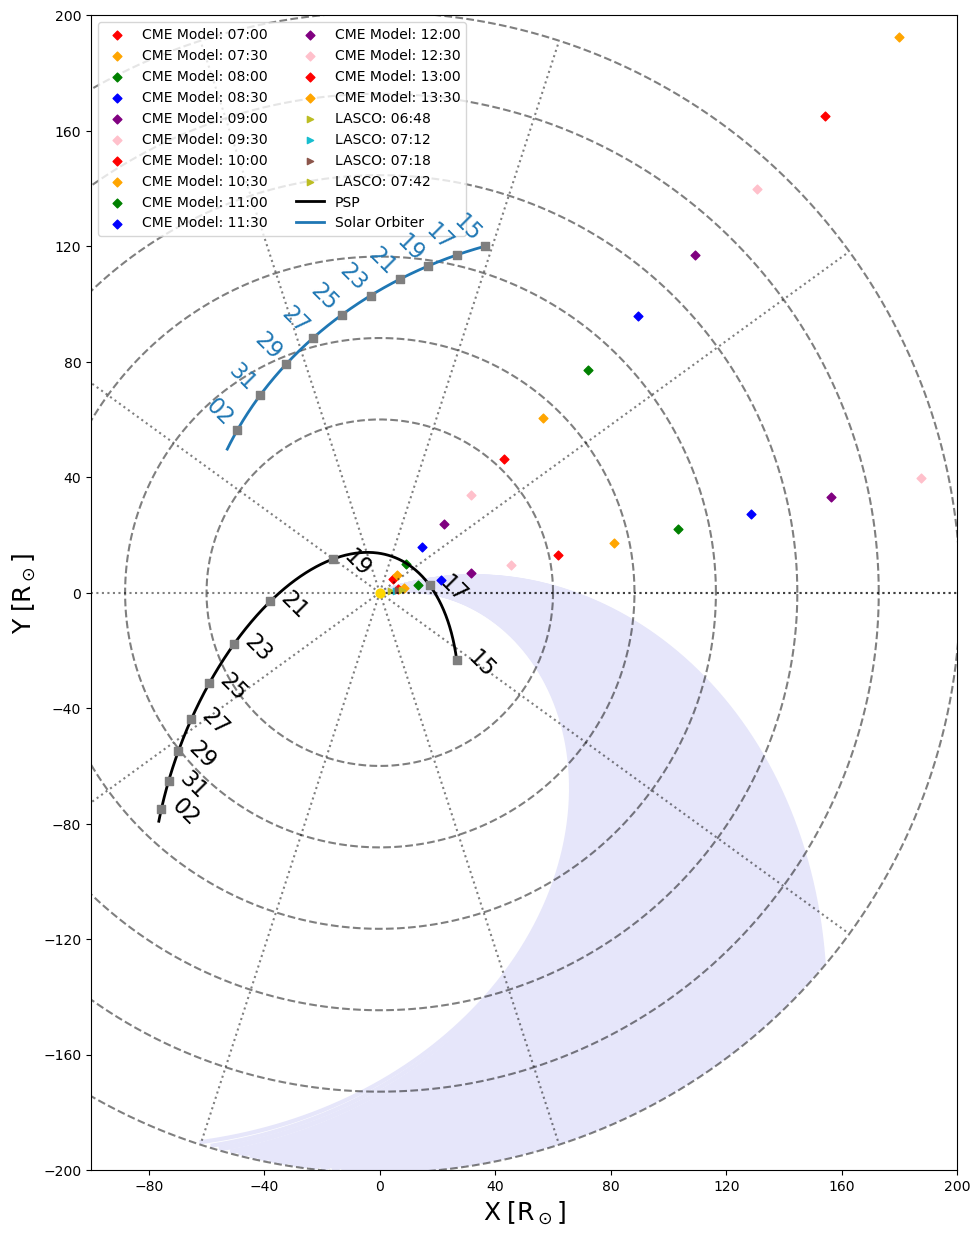

In [279]:
psp_coords = psp_inertial.transform_to(scoords.HeliocentricInertial)
solo_coords = solo_inertial.transform_to(scoords.HeliocentricInertial)

### Set up panels
fig, ax = plt.subplots(1, figsize=(12,15))

### TRAJECTORIES AND DATES
days=2
cp, cs, ca, cm, dcol = ['black', 'tab:blue', 'tab:red', 'tab:green', 'tab:gray']
label_cadence = 48*days
cc = ['r', 'orange', 'green', 'blue', 'purple', 'pink']
############ SUN
ax.scatter(0, 0, c='gold', marker='o', s=40, zorder=10)

# ############ CME
# ss, lw, mm = 20, 3, 'D'
# ec, erupc = 'tab:orange', 'tab:red'

# # Plot original triangle and semi circle
# a, l, h = ice_cream_model(angular_width, initial_radius)

# # eruption location
# r, p = np.sqrt(x0**2 + y0**2), np.arctan(y0/x0)

# # propagate this outwards
# for i, dt in enumerate(dt_common[14:]):
#     time_difference = dt - datetime.datetime(2023, 3, 15, 6, 48, 0)
#     if time_difference > datetime.timedelta(seconds=10):
#         time_step = time_difference.total_seconds() // 60
#         new_radius = initial_radius + i * velocity * time_step * u.minute 
#         a, l, h = ice_cream_model(angular_width, new_radius)
#         p1 = p + np.arctan(a / h)
#         p2 = p - np.arctan(a / h)
#         x1, y1 = h * np.cos(p1), h * np.sin(p1)
#         x2, y2 = h * np.cos(p2), h * np.sin(p2)
#         if np.logical_and(x1 < 200*u.Rsun, y1 < 200*u.Rsun):
#             ax.scatter(x1, y1, c=cc[i%6], marker=mm, s=ss, label=f"CME Model: {dt.hour:02d}:{dt.minute:02d}")
#             ax.scatter(x2, y2, c=cc[i%6], marker=mm,  s=ss)

# # scatter the lasco points
# ax.scatter(xL[0], yL[0], c='tab:olive', s=ss, marker='>', label='LASCO: 06:48')
# ax.scatter(xL[1], yL[1], c='tab:cyan', s=ss, marker='>', label='LASCO: 07:12')
# ax.scatter(xL[2], yL[2], c='tab:brown', s=ss, marker='>', label='LASCO: 07:18')
# ax.scatter(xL[3], yL[3], c='tab:olive', s=ss, marker='>', label='LASCO: 07:42')

# ############ SA STREAM
# for xx in np.arange(200, 400, step=2):
#     for j in np.arange(9, 20, step=2):
#         parker1 = parker_streamline(
#                 phi0= j*u.deg,
#                 r0 = 2.5*u.R_sun,
#                 rmax = 200*u.R_sun,
#                 v_sw=xx*u.km/u.s
#             )
#         ax.plot(parker1[0]*np.cos(parker1[1]),
#                     parker1[0]*np.sin(parker1[1]),
#                     color=scol,linewidth=3,zorder=-1
#                 ) 


############ TRAJECTORIES
### PARKER
psp_coords = psp_coords.transform_to()
psp_coords.representation_type="cartesian"
ax.plot(
    psp_coords.x.to("R_sun"),
    psp_coords.y.to("R_sun"),
    color=cp,linewidth=2,label="PSP",zorder=10
)
ax.scatter(
    psp_coords.x.to("R_sun")[::label_cadence],
    psp_coords.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10
)

### ORBITER
solo_coords.representation_type="cartesian"
ax.plot(
    solo_coords.x.to("R_sun"),
    solo_coords.y.to("R_sun"),
    color=cs,linewidth=2,label="Solar Orbiter",zorder=10
)
ax.scatter(
    solo_coords.x.to("R_sun")[::label_cadence],
    solo_coords.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10
)

### LABEL DATES
for dt,pspc,soc in zip(dt_common[::label_cadence],
                       psp_coords[::label_cadence],
                       solo_coords[::label_cadence]) :
    ax.text(pspc.x.to("R_sun").value+2,
                 pspc.y.to("R_sun").value+5,
                f"{dt.day:02d}",rotation=-45,color=cp,
                verticalalignment="top",
                horizontalalignment="left",zorder=10,fontsize=16
               )
    ax.text(soc.x.to("R_sun").value,
                 soc.y.to("R_sun").value,
                 f"{dt.day:02d}",rotation=-45,color=cs,
                 verticalalignment="bottom",
                 horizontalalignment="right",zorder=10,
                 fontsize=16
               )

### Gridlines / Axis Lables ETC for ax
ax.set_aspect(1)
rmax=200
rgrids = np.linspace(60, rmax+1, 6)
for R_ in rgrids  :
    ax.plot(R_*np.cos(np.linspace(0,2*np.pi,300)),
            R_*np.sin(np.linspace(0,2*np.pi,300)),
            color="black",linestyle="--",alpha=0.5
           )
rmax=rmax    
for phi in np.radians(np.linspace(0,360,11)) :
    ax.plot([0,rmax*np.cos(phi)],[0,rmax*np.sin(phi)],
            color="black",linestyle=":",alpha=0.5
           )
ax.set_xticks(np.linspace(-rmax,rmax,11))
ax.set_yticks(np.linspace(-rmax,rmax,11))
ax.set_xlim([-100,rmax])
ax.set_ylim([-rmax,rmax])
ax.set_xlabel(r"$\rm X \; [R_\odot]$", fontsize=18)
ax.set_ylabel(r"$\rm Y \; [R_\odot]$", fontsize=18)
ax.legend(loc='upper left', ncol=2)

plt.savefig(os.path.join(FIG_DIR, 'E15_.png'))

# OG Figure

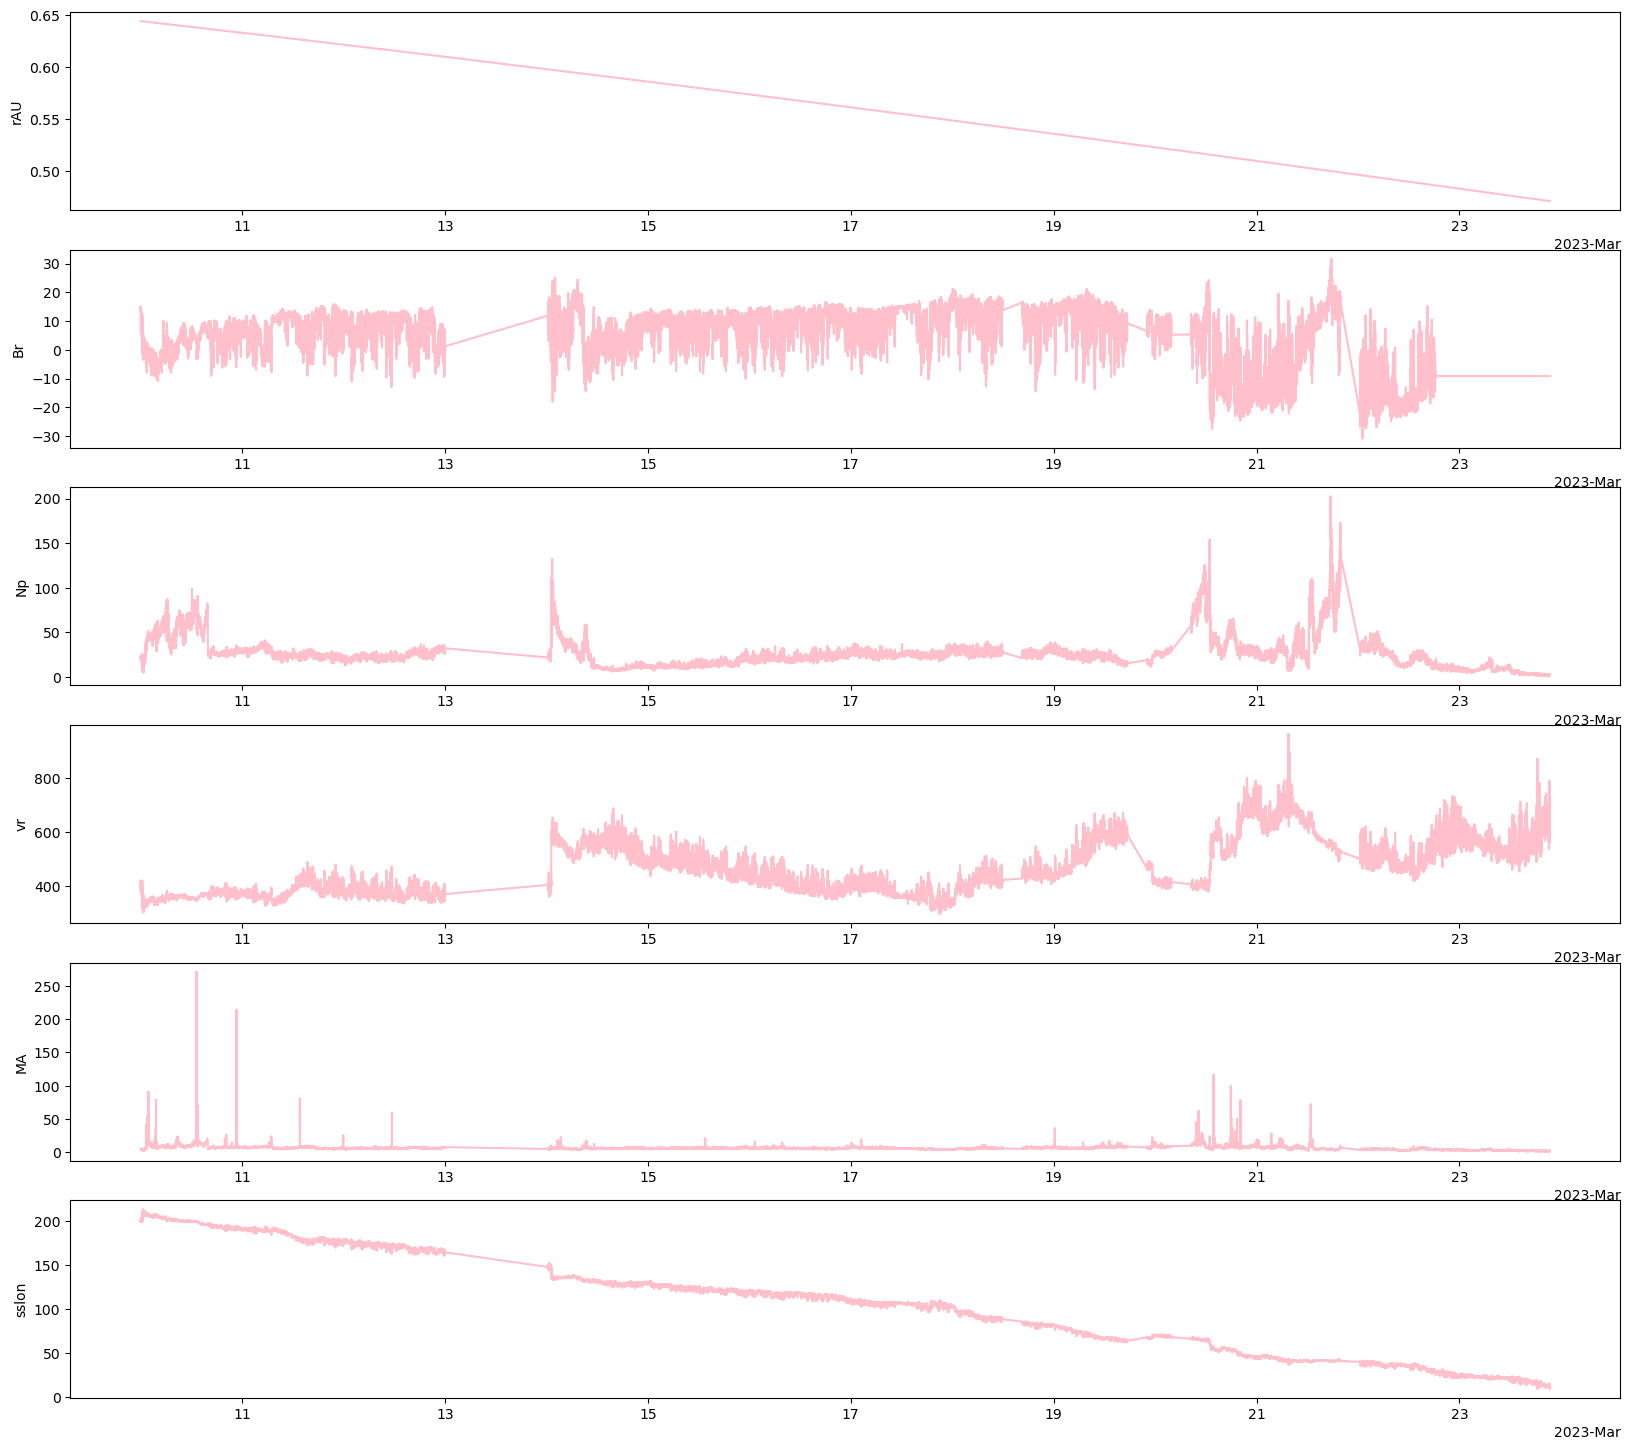

In [179]:
# psp_coords = psp_inertial.transform_to(scoords.HeliocentricInertial)
# solo_coords = solo_inertial.transform_to(scoords.HeliocentricInertial)

# ### Set up panels
# fig, ax = plt.subplots(1, figsize=(12,15))

# ### TRAJECTORIES AND DATES
# days=2
# cp, cs, ca, cm, dcol = ['black', 'tab:blue', 'tab:red', 'tab:green', 'tab:gray']
# label_cadence = 48*days
# cc = ['r', 'orange', 'green', 'blue', 'purple', 'pink']
# ############ SUN
# ax.scatter(0, 0, c='gold', marker='o', s=40, zorder=10)

# ############ CME
# ss, lw, mm = 20, 3, 'D'
# ec, erupc = 'tab:orange', 'tab:red'

# # Plot original triangle and semi circle
# a, l, h = ice_cream_model(angular_width, initial_radius)

# # eruption location
# r, p = np.sqrt(x0**2 + y0**2), np.arctan(y0/x0)

# # propagate this outwards
# for i, dt in enumerate(dt_common[14:]):
#     time_difference = dt - datetime.datetime(2023, 3, 15, 6, 48, 0)
#     if time_difference > datetime.timedelta(seconds=10):
#         time_step = time_difference.total_seconds() // 60
#         new_radius = initial_radius + i * velocity * time_step * u.minute 
#         a, l, h = ice_cream_model(angular_width, new_radius)
#         p1 = p + np.arctan(a / h)
#         p2 = p - np.arctan(a / h)
#         x1, y1 = h * np.cos(p1), h * np.sin(p1)
#         x2, y2 = h * np.cos(p2), h * np.sin(p2)
#         if np.logical_and(x1 < 200*u.Rsun, y1 < 200*u.Rsun):
#             ax.scatter(x1, y1, c=cc[i%6], marker=mm, s=ss, label=f"CME Model: {dt.hour:02d}:{dt.minute:02d}")
#             ax.scatter(x2, y2, c=cc[i%6], marker=mm,  s=ss)

# # scatter the lasco points
# ax.scatter(xL[0], yL[0], c='tab:olive', s=ss, marker='>', label='LASCO: 06:48')
# ax.scatter(xL[1], yL[1], c='tab:cyan', s=ss, marker='>', label='LASCO: 07:12')
# ax.scatter(xL[2], yL[2], c='tab:brown', s=ss, marker='>', label='LASCO: 07:18')
# ax.scatter(xL[3], yL[3], c='tab:olive', s=ss, marker='>', label='LASCO: 07:42')

# ############ SA STREAM
# for xx in np.arange(200, 400, step=2):
#     for j in np.arange(9, 20, step=2):
#         parker1 = parker_streamline(
#                 phi0= j*u.deg,
#                 r0 = 2.5*u.R_sun,
#                 rmax = 200*u.R_sun,
#                 v_sw=xx*u.km/u.s
#             )
#         ax.plot(parker1[0]*np.cos(parker1[1]),
#                     parker1[0]*np.sin(parker1[1]),
#                     color=scol,linewidth=3,zorder=-1
#                 ) 


# ############ TRAJECTORIES
# ### PARKER
# psp_coords.representation_type="cartesian"
# ax.plot(
#     psp_coords.x.to("R_sun"),
#     psp_coords.y.to("R_sun"),
#     color=cp,linewidth=2,label="PSP",zorder=10
# )
# ax.scatter(
#     psp_coords.x.to("R_sun")[::label_cadence],
#     psp_coords.y.to("R_sun")[::label_cadence],
#     color=dcol, marker='s',zorder=10
# )

# ### ORBITER
# solo_coords.representation_type="cartesian"
# ax.plot(
#     solo_coords.x.to("R_sun"),
#     solo_coords.y.to("R_sun"),
#     color=cs,linewidth=2,label="Solar Orbiter",zorder=10
# )
# ax.scatter(
#     solo_coords.x.to("R_sun")[::label_cadence],
#     solo_coords.y.to("R_sun")[::label_cadence],
#     color=dcol, marker='s',zorder=10
# )

# ### LABEL DATES
# for dt,pspc,soc in zip(dt_common[::label_cadence],
#                        psp_coords[::label_cadence],
#                        solo_coords[::label_cadence]) :
#     ax.text(pspc.x.to("R_sun").value+2,
#                  pspc.y.to("R_sun").value+5,
#                 f"{dt.day:02d}",rotation=-45,color=cp,
#                 verticalalignment="top",
#                 horizontalalignment="left",zorder=10,fontsize=16
#                )
#     ax.text(soc.x.to("R_sun").value,
#                  soc.y.to("R_sun").value,
#                  f"{dt.day:02d}",rotation=-45,color=cs,
#                  verticalalignment="bottom",
#                  horizontalalignment="right",zorder=10,
#                  fontsize=16
#                )

# ### Gridlines / Axis Lables ETC for ax
# ax.set_aspect(1)
# rmax=200
# rgrids = np.linspace(60, rmax+1, 6)
# for R_ in rgrids  :
#     ax.plot(R_*np.cos(np.linspace(0,2*np.pi,300)),
#             R_*np.sin(np.linspace(0,2*np.pi,300)),
#             color="black",linestyle="--",alpha=0.5
#            )
# rmax=rmax    
# for phi in np.radians(np.linspace(0,360,11)) :
#     ax.plot([0,rmax*np.cos(phi)],[0,rmax*np.sin(phi)],
#             color="black",linestyle=":",alpha=0.5
#            )
# ax.set_xticks(np.linspace(-rmax,rmax,11))
# ax.set_yticks(np.linspace(-rmax,rmax,11))
# ax.set_xlim([-100,rmax])
# ax.set_ylim([-rmax,rmax])
# ax.set_xlabel(r"$\rm X \; [R_\odot]$", fontsize=18)
# ax.set_ylabel(r"$\rm Y \; [R_\odot]$", fontsize=18)
# ax.legend(loc='upper left', ncol=2)

# plt.savefig('CME_LASCO_Trajectory_inertial.png')